###  1: Load the “bank-full.csv” dataset and create a logistic regression model. 

In [1]:
import pandas as pd
import time

#load data
df = pd.read_csv("bank-full.csv",sep=';')
print(df.head())
print("\n Missing values in each column:")
print(df.isnull().sum())

#convert target variable to binary
df['y'] = df['y'].map({'yes':1,'no':0})
print("\ndata types:",df.dtypes)

#convert categorical column using one-hot encoding
categorical_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("\nShape before encoding:",df.shape)
print("\nShape after encoding:",df_encoded.shape)

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  

 Missing values in each column:
age          0
job          0
marital      0
education    0
default      0
bal


Model Performance
Accuracy:0.9038
Precision:0.6715
Recall:0.3478
F1:0.4583
Roc-Auc:0.9111

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.67      0.35      0.46      1058

    accuracy                           0.90      9043
   macro avg       0.80      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



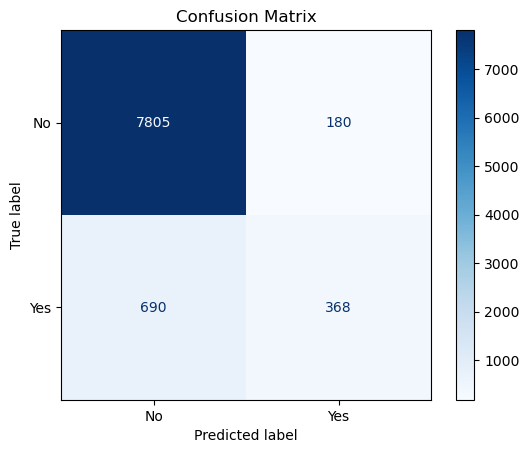

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,roc_auc_score,confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Separate features and target variable
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

start_time = time.time()
#Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled,y_train)
#####
end_time = time.time()
training_time = end_time - start_time

#prediction
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:,1]

#### Evaluation ###

#accuracy
base_accuracy = accuracy_score(y_test,y_pred)
#precision
base_precision  = precision_score(y_test,y_pred)
#recall
base_recall = recall_score(y_test,y_pred)
#f1 score
base_f1 = f1_score(y_test,y_pred)
#roc_auc score
base_roc_auc = roc_auc_score(y_test,y_pred_proba)
#classification
base_classification = classification_report(y_test,y_pred)

print("\nModel Performance")
print(f"Accuracy:{base_accuracy:.4f}")
print(f"Precision:{base_precision:.4f}")
print(f"Recall:{base_recall:.4f}")
print(f"F1:{base_f1:.4f}")
print(f"Roc-Auc:{base_roc_auc:.4f}")

print("\nClassification Report")
print(base_classification)

######
result_base = {
    "best_params": "Default",  # No tuning for base model
    "best_score_cv": "N/A",    # No CV for base model
    "accuracy": base_accuracy,
    "precision": base_precision,
    "recall": base_recall,
    "f1_score": base_f1,
    "roc_auc": base_roc_auc,
    "classification_report": base_classification,
    "training_time":training_time
}
######

#confustion matrix
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No','Yes'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()




    Model & Data: Logistic Regression was trained to predict client subscription to a term deposit using a Portuguese bank dataset. Data was preprocessed with one-hot encoding and feature scaling, and an 80/20 train-test split was used.
    
    Accuracy: High at 90.38%, showing strong overall performance.   
    Recall: Low for the positive class (34.78%), meaning many actual subscribers were missed.
    Precision: Moderate (67.15%), indicating predictions of subscription are correct about two-thirds of the time.
    F1-Score: Low (45.83%), reflecting imbalance between precision and recall.
    ROC AUC: High (0.9111), showing the model can effectively discriminate between subscribers and non-subscribers.
    
    Interpretation: The model performs well on the majority class but struggles with the minority class; adjusting the classification threshold could improve recall without severely impacting precision.

###  2: Add and Tune with Hyperparameters

In [3]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#### Define simple parameter grid for Hyperparameter tuning!!! 
#### since it is a repeatative process , I built a function

def tune_logistic_regression(param_grid, X_train_scaled, y_train, X_test_scaled, y_test):
    # Initialize Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    
    # Grid Search setup
    grid_search = GridSearchCV(
        estimator=logreg,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=0  # silent run
    )

    ########
    start_time = time.time()
    # Fit GridSearchCV
    grid_search.fit(X_train_scaled, y_train)
    ########
    end_time = time.time()
    training_time = end_time - start_time
    # Best model & predictions
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    class_report = classification_report(y_test, y_pred)

    return {
        "best_model": best_model,
        "best_params": best_params,
        "best_score_cv": best_score,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "classification_report": class_report,
        "cv_results": grid_search.cv_results_,
        "training_time":training_time
    }

### Now test with a simple paramater grid, this time I will use l1 regularized  mode for Ques:2

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}
############################

results_l1 = tune_logistic_regression(param_grid, X_train_scaled, y_train, X_test_scaled, y_test)

###########################

print("\n Optimized Logistic Regression Performance (GridSearchCV)")
print("Best Parameters:", results_l1["best_params"])
print("  Before tuning    |   After hyperparameter tuning")

print(f"Accuracy:  {result_base["accuracy"]:.4f} \t {results_l1["accuracy"]:.4f}")
print(f"Precision: {result_base["precision"]:.4f} \t {results_l1["precision"]:.4f}")
print(f"Recall:    {result_base["recall"]:.4f} \t {results_l1["recall"]:.4f}")
print(f"F1 Score:  {result_base["f1_score"]:.4f} \t {results_l1["f1_score"]:.4f}")
print(f"ROC-AUC:   {result_base["roc_auc"]:.4f} \t {results_l1["roc_auc"]:.4f}")

print("\nClassification Report before  Tuning")
print(result_base["classification_report"])
print("\nClassification Report after hyperparameter Tuning")
print(results_l1["classification_report"]) 



 Optimized Logistic Regression Performance (GridSearchCV)
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
  Before tuning    |   After hyperparameter tuning
Accuracy:  0.9038 	 0.8494
Precision: 0.6715 	 0.4263
Recall:    0.3478 	 0.8308
F1 Score:  0.4583 	 0.5635
ROC-AUC:   0.9111 	 0.9142

Classification Report before  Tuning
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.67      0.35      0.46      1058

    accuracy                           0.90      9043
   macro avg       0.80      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043


Classification Report after hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.43      0.83      0.56      1058

    accuracy                           0.85      9043
   macro avg       0.70  

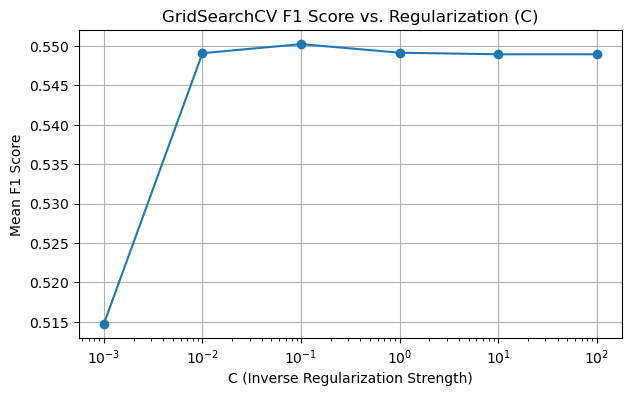

In [4]:

# Convert results to DataFrame
results_df = pd.DataFrame(results_l1["cv_results"])

# Plotting
plt.figure(figsize=(7,4))
plt.plot(results_df['param_C'], results_df['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Mean F1 Score')
plt.title('GridSearchCV F1 Score vs. Regularization (C)')
plt.grid(True)
plt.show()


    In the initial logistic regression model, no hyperparameter tuning was applied apart from max_iter. Therefore, that model achieved high overall accuracy (0.9038) and precision (0.6715) but had very low recall (0.3478), indicating that it failed to identify a large portion of customers who actually subscribed to a term deposit. 

    To improve performance, hyperparameter tuning was performed using GridSearchCV, exploring combinations of regularization strength (C), penalty type (l1, l2, elasticnet), and solver (liblinear, saga). For Ques 2, we used l1, and the best model was identified with 'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'.

    Although the tuned model showed a slight drop in accuracy (0.8494) and precision (0.4263), it achieved a substantial improvement in recall (0.8308) and F1 score (0.5635). The ROC-AUC score also increased from 0.9111 to 0.9142, indicating a much stronger ability to distinguish between the classes. 

    Overall, the tuned model provides a better balance between precision and recall and is more effective at identifying true positive cases (i.e., subscribers). Therefore, it is more suitable for deployment in scenarios where identifying potential subscribers is critical, such as targeted marketing campaigns.

###  3: Two regularized logistic regression models.

In [5]:
import numpy as np
### Now for Ques 3, I will use two regularized logistic regression models 
### since I have used l1 already, now I use l2 and elasticnet 
### I use the tune_logistic_regression function what I have built for hyperparameter tuning
# This function print the output
def report_model_performance(name, results):
    print(f"\n--- {name} Logistic Regression Performance Report ---")
    print(f"Best Parameters: {results['best_params']}")
    print(f"Cross-Validated F1 Score: {results['best_score_cv']:.4f}")
    print(f"Test Accuracy: {results['accuracy']:.4f}")
    print(f"Test Precision: {results['precision']:.4f}")
    print(f"Test Recall: {results['recall']:.4f}")
    print(f"Test F1 Score: {results['f1_score']:.4f}")
    print(f"Test ROC-AUC Score: {results['roc_auc']:.4f}")
    print("Classification Report:\n", results['classification_report'])

# L2 Regularization Grid (Ridge)
param_grid_l2 = {
    'penalty': ['l2'],
    'C': np.logspace(-4, 2, 10),
    'solver': ['liblinear'],  # supports L2
    'class_weight': ['balanced']
}

# ElasticNet Regularization Grid
param_grid_elasticnet = {
    'penalty': ['elasticnet'],
    'C': np.logspace(-4, 2, 10),
    'solver': ['saga'],  # saga supports elasticnet
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'class_weight': ['balanced']
}

# L2 Regularization
results_l2 = tune_logistic_regression(param_grid_l2, X_train_scaled, y_train, X_test_scaled, y_test)

# ElasticNet Regularization
results_elastic = tune_logistic_regression(param_grid_elasticnet, X_train_scaled, y_train, X_test_scaled, y_test)

# Report for both models
report_model_performance("L2", results_l2)
report_model_performance("ElasticNet", results_elastic)



--- L2 Logistic Regression Performance Report ---
Best Parameters: {'C': np.float64(0.21544346900318823), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Cross-Validated F1 Score: 0.5490
Test Accuracy: 0.8493
Test Precision: 0.4261
Test Recall: 0.8308
Test F1 Score: 0.5633
Test ROC-AUC Score: 0.9143
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.43      0.83      0.56      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.84      0.74      9043
weighted avg       0.91      0.85      0.87      9043


--- ElasticNet Logistic Regression Performance Report ---
Best Parameters: {'C': np.float64(0.0001), 'class_weight': 'balanced', 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
Cross-Validated F1 Score: 0.5543
Test Accuracy: 0.8663
Test Precision: 0.4566
Test Recall: 0.7514
Test F1 Score: 0.5681
Test ROC-AUC Scor

###  4: Compare the performance of the three models (Q1 and Q3)


In [6]:
# Compare all the models
# Store metrics in a dictionary
# Allow full display of wide columns (like dictionaries)

pd.set_option('display.max_colwidth', None)
# Store all results in a dictionary of models
all_results = {
    "Base": result_base,
    "L1": results_l1,
    "L2": results_l2,
    "ElasticNet": results_elastic
}

# Extract performance metrics into a list of rows
performance_data = []

for name, result in all_results.items():
    performance_data.append({
        "Model": name,
        "Accuracy": result["accuracy"],
        "Precision": result["precision"],
        "Recall": result["recall"],
        "F1 Score": result["f1_score"],
        "ROC AUC": result["roc_auc"],
        "Best CV F1": result.get("best_score_cv", "N/A"),
        "Best Params": result.get("best_params", "Default"),
        "Training Time(sec)":result["training_time"]
    })

# Convert to DataFrame
performance_df = pd.DataFrame(performance_data)

# Print the comparison table
print("Model Performance Comparison:\n")
print(performance_df)

# Identify best model based on F1 Score (you can change to Accuracy or AUC if needed)
best_model_row = performance_df.loc[performance_df['F1 Score'].idxmax()]
best_model_name = best_model_row['Model']

# Output best model summary
print(f"\n The best performing model is **{best_model_name}**, with:")
print(f"F1 Score = {best_model_row['F1 Score']:.4f} , Recall = {best_model_row['Recall']:.4f}, Accuracy = {best_model_row['Accuracy']:.4f}, ROC AUC = {best_model_row['ROC AUC']:.4f}.")
print(f"Best hyperparameters found: {best_model_row['Best Params']}")

Model Performance Comparison:

        Model  Accuracy  Precision    Recall  F1 Score   ROC AUC Best CV F1  \
0        Base  0.903793   0.671533  0.347826  0.458281  0.911091        N/A   
1          L1  0.849386   0.426285  0.830813  0.563462  0.914205    0.55025   
2          L2  0.849276   0.426079  0.830813  0.563281  0.914304   0.549007   
3  ElasticNet  0.866305   0.456634  0.751418  0.568060  0.907294   0.554278   

                                                                                             Best Params  \
0                                                                                                Default   
1                         {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}   
2         {'C': 0.21544346900318823, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}   
3  {'C': 0.0001, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}   

   Training Time(sec)  
0       

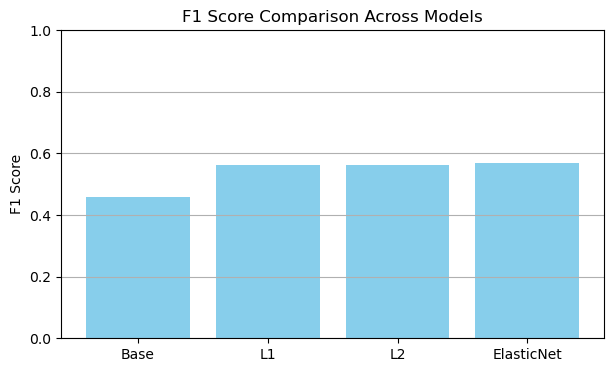

In [7]:
# Save to CSV if needed
performance_df.to_csv("model_comparison.csv", index=False)

# Plot F1 scores for visual comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(performance_df["Model"], performance_df["F1 Score"], color='skyblue')
plt.title("F1 Score Comparison Across Models")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

Model Performance Comparison

         Model  Accuracy  Precision    Recall    F1 Score   ROC AUC 
          Base  0.903793   0.671533    0.347826  0.458281   0.911091        
            L1  0.849386   0.426285    0.830813  0.563462   0.914205    
            L2  0.849276   0.426079    0.830813  0.563281   0.914304      
    ElasticNet  0.866305   0.456634    0.751418  0.568060   0.907294    

    1. The dataset is imbalanced, so accuracy alone for base model (90%) is misleading.
    2. Base model has the highest precision (0.671) but very low recall (0.347), meaning it misses most subscribers.
    3. L1 and L2 models achieve the highest recall (0.830), catching most potential subscribers, but their precision is low (0.426), leading to many false positives (wasted calls).
    4. ElasticNet provides the best balance: recall (0.751) remains high while precision improves (0.456), resulting in the highest F1 score (0.568) among all models.
    5. ROC-AUC is high (~0.91) across all models, meaning the models can discriminate well between classes.

    Interpretation: ElasticNet is the best-performing model overall because it balances recall and precision, making it more practical for direct marketing where the goal is to catch as many subscribers as possible while reducing wasted efforts.

###  5: KNN and tune K on the training set

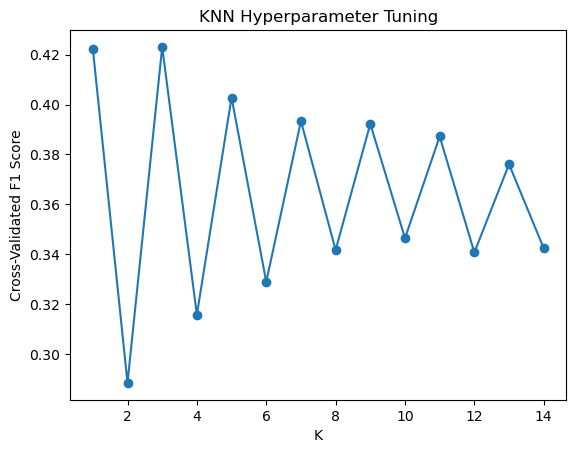

Optimal K: 3


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_values = range(1, 15)
f1_scores_knn = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    f1 = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='f1').mean()
    f1_scores_knn.append(f1)

# Plot
plt.plot(k_values, f1_scores_knn, marker='o')
plt.xlabel("K")
plt.ylabel("Cross-Validated F1 Score")
plt.title("KNN Hyperparameter Tuning")
plt.show()

# Find best K
best_k = k_values[np.argmax(f1_scores_knn)]
print(f"Optimal K: {best_k}")

In [9]:
#### Now comparing all the models
start_time = time.time()
# Train with best K
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)
###########
end_time = time.time()
training_time = end_time - start_time
###########
# Evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

y_pred_knn = best_knn.predict(X_test_scaled)
y_prob_knn = best_knn.predict_proba(X_test_scaled)[:, 1]

results_knn = {
    "Model":"KNN",
    "accuracy": accuracy_score(y_test, y_pred_knn),
    "precision": precision_score(y_test, y_pred_knn),
    "recall": recall_score(y_test, y_pred_knn),
    "f1_score": f1_score(y_test, y_pred_knn),
    "roc_auc": roc_auc_score(y_test, y_prob_knn),
    "classification_report": classification_report(y_test, y_pred_knn),
    "best_score_cv": max(f1_scores_knn),  # from CV tuning
    "best_params": {"n_neighbors": best_k},
    "training_time":training_time
}
###################################################
### update the all_result since new model KNN found
###################################################
performance_data.append({
    "Model": "KNN",
    "Accuracy": results_knn["accuracy"],
    "Precision": results_knn["precision"],
    "Recall": results_knn["recall"],
    "F1 Score": results_knn["f1_score"],
    "ROC AUC": results_knn["roc_auc"],
    "Best CV F1": results_knn.get("best_score_cv", "N/A"),
    "Best Params": results_knn.get("best_params", "Default"),
    "Training Time(sec)":results_knn["training_time"]
})

# Convert to DataFrame
performance_df = pd.DataFrame(performance_data)
#########################
#########################

# Print the comparison table
print("Model Performance Comparison:\n")
print(performance_df)

# Identify best model based on F1 Score (you can change to Accuracy or AUC if needed)
best_model_row = performance_df.loc[performance_df['F1 Score'].idxmax()]
best_model_name = best_model_row['Model']

# Output best model summary
print(f"\n The best performing model is **{best_model_name}**, with:")
print(f"F1 Score = {best_model_row['F1 Score']:.4f}, Accuracy = {best_model_row['Accuracy']:.4f}, ROC AUC = {best_model_row['ROC AUC']:.4f}.")
print(f"Best hyperparameters found: {best_model_row['Best Params']}")




Model Performance Comparison:

        Model  Accuracy  Precision    Recall  F1 Score   ROC AUC Best CV F1  \
0        Base  0.903793   0.671533  0.347826  0.458281  0.911091        N/A   
1          L1  0.849386   0.426285  0.830813  0.563462  0.914205    0.55025   
2          L2  0.849276   0.426079  0.830813  0.563281  0.914304   0.549007   
3  ElasticNet  0.866305   0.456634  0.751418  0.568060  0.907294   0.554278   
4         KNN  0.888975   0.540179  0.343100  0.419653  0.772675   0.423081   

                                                                                             Best Params  \
0                                                                                                Default   
1                         {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}   
2         {'C': 0.21544346900318823, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}   
3  {'C': 0.0001, 'class_weight': 'balanced', 'l1_ratio': 0.1, 

### Comparison and Discussion

To compare K-Nearest Neighbors (KNN) with the four logistic regression models (Base, L1, L2, and ElasticNet), we examine three main aspects: the number of trainable parameters, training time, and model performance.

1. Number of Trainable Parameters:

        # Logistic Regression (Base, L1, L2, ElasticNet)
                Parametric models: learn a fixed set of weights and a bias term.
                Number of trainable parameters is proportional to the number of input features.
                Base uses default settings without regularization.
                L1, L2, ElasticNet apply regularization (L1: sparsity, L2: weight shrinkage, ElasticNet: balance between L1 & L2).

        # KNN
                Non-parametric model: stores the training dataset in memory; no coefficients are learned.
                Zero trainable parameters — beneficial for small datasets, inefficient for large-scale data.

2. Training Time: (It can be varied)

               Fastest: KNN (0.014416 sec)—minimal computation during training.  
               Logistic regression models require optimization:       
               Base: 0.099274  sec  
               L1:   7.946513  sec  
               L2:   7.335536  sec  
               ElasticNet: 112.848524 sec (slowest due to combined penalties and iterative optimization).

4. Model Performance:

                The ElasticNet logistic regression model provided the best overall performance, whereas the KNN model, while having a decent accuracy of 0.888, had lower scores of F1 and recall.

        Model       Accuracy  Precision  Recall    F1 Score  ROC AUC 
        Base        0.903793   0.671533  0.347826  0.458281  0.911091         
        L1          0.849386   0.426285  0.830813  0.563462  0.914205   
        L2          0.849276   0.426079  0.830813  0.563281  0.914304      
        ElasticNet  0.866305   0.456634  0.751418  0.568060  0.907294     
        KNN         0.888975   0.540179  0.343100  0.419653  0.772675    
                    
                The Base (0.90) showed the highest accuracy, and L1, L2 models showed also show high accuracy (almost 0.84), but recall was low for Base (0.34). However, the recall was pretty high for L1 and L2 approximately 0.83. Additionally, the F1 score is also high for L1 and L2 but the highest for ElasticNet (0.568). KNN also struggled with recall, leading to a lower F1 score.

5. Interpretation:

                ElasticNet: The best-performing model with F1 = 0.5680, Accuracy = 0.866, and ROC AUC = 0.907. It balances recall (0.751) and precision (0.456) better than the others, though training time is higher.

                L1 and L2 Logistic Regression: Achieve very high recall (~0.831) but lower precision (~0.426), giving slightly lower F1 scores compared to ElasticNet.

                Base and KNN: Base has high accuracy (~0.904) but very poor recall (~0.348), missing many positives. KNN trains very fast but performs worst overall in recall (0.343), F1 (0.420), and ROC AUC (0.773).

                This aligns with the metrics while emphasizing ElasticNet as the best model.
   

In [10]:
import joblib

# Save model
joblib.dump(results_l1["best_model"], "best_l1_model.pkl")

# Save scaler
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

### Apply the model on another set of Test data.

In [11]:
### Now I will load another set of bank data and predict the outcome
# Load model & scaler
model = joblib.load("best_l1_model.pkl")
scaler = joblib.load("scaler.pkl")

###############
#load data
df_test = pd.read_csv("bank.csv",sep=';')
#convert target variable to binary
df_test['y'] = df_test['y'].map({'yes':1,'no':0})
#convert categorical column using one-hot encoding
categorical_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']
df_encoded_test = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)
###############

X_new = df_encoded_test.drop('y', axis=1)
y_true_new = df_encoded_test['y']

# Scale & predict
X_new_scaled = scaler.transform(X_new)
y_pred_new = model.predict(X_new_scaled)
y_pred_proba_new = logreg.predict_proba(X_new_scaled)[:,1]

###############

print("\nModel Performance")
print(f"Accuracy: {accuracy_score(y_true_new, y_pred_new):.4f}")
print(f"Precision: {precision_score(y_true_new, y_pred_new):.4f}")
#print(f"Precision:{base_precision:.4f}")
print(f"Recall:{recall_score(y_true_new, y_pred_new):.4f}")
print(f"F1:{f1_score(y_true_new, y_pred_new):.4f}")
print(f"Roc-Auc: {roc_auc_score(y_true_new, y_pred_proba_new):.4f}")

print("\nClassification Report")
print(classification_report(y_true_new, y_pred_new))


Model Performance
Accuracy: 0.8370
Precision: 0.3967
Recall:0.7965
F1:0.5297
Roc-Auc: 0.8975

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      4000
           1       0.40      0.80      0.53       521

    accuracy                           0.84      4521
   macro avg       0.68      0.82      0.72      4521
weighted avg       0.90      0.84      0.86      4521



Model Performance on Test Data

    Accuracy: 0.8370 — slightly lower than training, showing balanced predictions on unseen data.
    Precision: 0.3967 — about 40% of predicted subscribers are correct.
    Recall: 0.7965 — the model successfully identifies ~80% of actual subscribers.
    F1-Score: 0.5297 — reflects a balance between precision and recall.
    ROC AUC: 0.8975 — strong ability to discriminate between subscribers and non-subscribers.
Interpretation: 
        
        The tuned model focuses on high recall, capturing most potential subscribers, while maintaining moderate precision. Overall, it generalizes well and shows strong discriminative performance.